# 2D exploration of 6-hour mean-sea level pressure from ERA5 data

In this tutorial we will explore the ERA5 dataset provided by ECMWF. 
In particular, we will use mean-sea level pressure reanalysis data for **2019** with a sampling of 6 hours. 

## Download data

The first step to use `PySPOD` for investigating the mean sea level pressure (MSLP) from the ERA5 dataset is to download the relevant data. This step can require a few hours, depending on your internet connection and on how busy ECMWF server is. Note that the dataset for this tutorial is approximately 5.6GB.

In order to download the required data from ECMWF, you should create an account and follow the instructions here: https://cds.climate.copernicus.eu/api-how-to

Once you have an account to access ERA5 data, you can simply run:

    - `python3 ERA5_RA_2019_MSLP.py` for the smaller dataset (5.6GB)

This should download a netCDF file called `ERA5_RA_2019_MSLP.nc` in the current directory `tutorials/climate/ERA5_MSLP_2D/`. Please, make sure that you downloaded the data before proceeding further. 

## Loading and configuring data

Once we have gained access to ECMWF datasets and downloaded the required file `ERA5_RA_2019_MSLP.nc`, we can proceed to use `PySPOD` to identify coherent structures in the data. The first step from this perspective is to import the required libraries, including the custom libraries 

    - `from pyspod.spod_low_storage import SPOD_low_storage`
    - `from pyspod.spod_low_ram     import SPOD_low_ram`
    - `from pyspod.spod_streaming   import SPOD_streaming`

that include three different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines), and the third being a streaming algorithm, that required little amount of memory (both storage and RAM) but runs typically slower than the other two.

Note that we also import the custom library 

    - `import library.weights as weights`

that implements the weight matrix for data defined on a sphere (e.g. the atmospheric data we are using). 

In [1]:
import os
import sys
import time
import warnings
import xarray as xr
import numpy  as np
from pathlib import Path

# Current path
CWD = os.getcwd()

# Import library specific modules
sys.path.append("../../../")
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
from pyspod.spod_streaming   import SPOD_streaming
import pyspod.utils_weights as utils_weights



We then need to access the data in the netCDF file. We can first inspect it as follows

In [2]:
# Inspect and load data 
file = os.path.join(CWD,'ERA5_RA_2019_MSLP.nc')
ds = xr.open_dataset(file)
print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 2920)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2019-01-01 ... 2019-12-31T21:00:00
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-04-15 03:54:36 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...


the netCDF file contains 3 coordinates:
  - longitude, **with dimension 1440**
  - latitude, **with dimension 721**
  - time **with dimension is 2920**, 

along with 1 variable
  - msl (mean-sea level pressure), **with dimension (2920, 721, 1440)**.



We first define a list of variable names that are present in our data file and store them in a list called `variables`. We then load in RAM the `time` coordinate, and the two spatial coordinates `longitude` and `latitude`, and store them into three different arrays, `t`, `x1` and `x2`, respectively. Let's look at their dimensions to see the number of time snapshots, and the length of longitude and latitude. 

In [3]:
# we extract time, longitude and latitude
variables = ['msl']
t = np.array(ds['time'])
x1 = np.array(ds['longitude'])
x2 = np.array(ds['latitude'])
print('shape of t (time): ', t.shape)
print('shape of x1 (longitude): ', x1.shape)
print('shape of x2 (latitude) : ', x2.shape)

shape of t (time):  (2920,)
shape of x1 (longitude):  (1440,)
shape of x2 (latitude) :  (721,)


We now need to load the data in a format that is suitable to the `PySPOD` library, that is

  - first dimension must correspond to the number of time snapshots (8760 in our case)
  - last dimension should corresponds to the number of variables (1 in our case)
  - the remaining dimensions corresponds to the spatial dimensions (1440, and 721 in our case, that correspond to longitude and latitude).

In order to perform this step, we have two options. 
  1. Provide a function that reads the data and pass it to the PySPOD class under the argument `data_handler`, along with the path to the file containing the data.
  2. Load all the data in RAM and pass it to the PySPOD class (in this case, the argument `data_handler` will be set to `False`.

The first approach allows the efficient processing of large files that may not fit in RAM, and data is loaded sequentially when needed, thereby reducing significantly the amount of RAM required. The second approach is RAM intensive but may be faster.

Let's explore the first method, and define a function that can load the data for us at run time. The arguments of the reader function must be:

  - data (the path to the file containing our data)
  - t_0 (the start time of a time slice)
  - t_end (the end time of a time slice)
  - variables (the name of the variables contained in the file)

This template is general enough for many applications using netCDF, .mat, and other data files. Our reader function is defined below:

In [4]:
def read_data(data, t_0, t_end, variables): 
    if t_0 == t_end: ti = [t_0]
    else           : ti = np.arange(t_0,t_end)
    X = np.empty([len(ti), x2.shape[0], x1.shape[0], len(variables)])
    for i,var in enumerate(variables):
        X = np.array(ds[var].isel(time=ti))
        X = np.nan_to_num(X)
    return X

You can genearlly use the function template above, and modify it according to your needs.

Note that, in the case of t_0 = t_end, we select t_0 and just extract that snapshot. The function `read_data` will be passed to the constructor of the PySPOD class under the argument `data_handler`. If we were to load all the data in RAM upfront, we will pass the data to the constructor and set `data_handler` to `False`. Also, you should keep in mind that the reader you provide (likewise the data, if loaded upfront) must conform to the `PySPOD` data requirements, that is:  

<font color='green'> **DATA REQUIREMENT: the dimension of the data matrix must correspond to (time $\times$ spatial dimension shape $\times$ number of variables).** </font>

<font color='green'> **NOTE : we used `np.nan_to_num` to set possible NaN (not-a-number) to zero. The amount of NaN in this case is relatively small, and setting them to zero is a feasible approximation. For your specific application you might want to apply a different replacement for NaN (if present).**</font>

## Settings required and optional parameters

Once our data is in a shape suitable to the `PySPOD` library, we define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `time_step`: time-sampling of the data (for now this must be constant)
- `n_snapshots`: number of time snapshots
- `n_space_dims`: number of spatial dimensions
- `n_variables`: number of variables
- `n_DFT`: length of FFT blocks

The optional parameters are as follows:
- `overlap`: dimension of the overlap region between adjacent blocks in percentage (0 to 100)
- `mean_type`: type of mean to be subtracted from the data (`longtime`, `blockwise` or `zero`)
- `normalize_weights`: weights normalization by data variance
- `normalize_data`: normalize data by variance
- `n_modes_save`: number of modes to be saved
- `conf_level`: calculate confidence level of modes
- `reuse_blocks`: whether to attempt reusing FFT blocks previously computed (if found)
- `savefft`: save FFT blocks to reuse them in the future (to save time)
- `savedir`: where to save the data


<font color='green'> **Note: we used the built-in module `utils_weights`, and in particular the function `utils_weights.geo_trapz_2d` to construct the weights for our problem on the sphere. This function builds weights according to lon-lat grids on the sphere and can be generally used for  two-dimensional atmospheric data. You can implement your own weights into the `custom` function inside `utils_weights.py` or by readily providing the weights as a numpy.ndarray. The weights must have a shape equal to the data spatial dimensions $\times$ number of variables, that is:**
    
$$\textsf{weights dim} = \textsf{spatial shape} \times \textsf{number of variables} = 1440 \times 721 \times 1 $$. </font>

In [5]:
# define required and optional parameters
params = dict()

# -- required parameters
params['time_step'   ] = 6                	# data time-sampling
params['n_snapshots' ] = t.shape[0]       	# number of time snapshots (we consider all data)
params['n_space_dims'] = 2                	# number of spatial dimensions (longitude and latitude)
params['n_variables' ] = len(variables)     # number of variables
params['n_DFT'       ] = np.ceil(24 * 30)   # length of FFT blocks (100 time-snapshots)

# -- optional parameters
params['overlap'          ] = 0 			# dimension block overlap region
params['mean_type'        ] = 'blockwise' 	# type of mean to subtract to the data
params['normalize_weights'] = False        	# normalization of weights by data variance
params['normalize_data'   ] = False   		# normalize data by data variance
params['n_modes_save'     ] = 3      		# modes to be saved
params['conf_level'       ] = 0.95   		# calculate confidence level
params['reuse_blocks'     ] = True 		    # whether to reuse blocks if present
params['savefft'          ] = True   		# save FFT blocks to reuse them in the future (saves time)
params['savedir'          ] = os.path.join(CWD, 'results', Path(file).stem) # folder where to save results

# Set weights
weights = utils_weights.geo_trapz_2D(
	x1_dim=x2.shape[0], x2_dim=x1.shape[0],
	n_vars=len(variables), R=1)


## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `SPOD_low_ram(data=ds, params=params, data_handler=read_data, variables=variables)` and the `fit` method, `SPOD_analysis.fit()`. 

The `PySPOD` constructor takes `X`, that can either be a `numpy.ndarray` containing the data or the path to the data file , the parameters `params`, a parameter called `data_handler` that can be either `False` or the function data reader (i.e. the `read_data` we defined earlier) and `variables` that is the list containing the names of our variables. If, as `data_handler`, we pass `False`, then we need to load the entire matrix of data into RAM, and that must comply with the **PySPOD** input data requirements (i.e. the dimension of the data matrix must correspond to (time $\times$ spatial dimension shape $\times$ number of variables). 

In more detail, the arguments to the constructor are defined as follows:

  - `X`: it can either be a `numpy.ndarray` and contain all data required for the analysis or a `str` containing the path to the data file. If we pass a `numpy.ndarray`, its dimensions must be equal to (time $\times$ spatial dimension shape $\times$ number of variables), and the argument `file_handler` must be set to `False`. If we pass a `str` containing the path to the data file, we need also to provide a data reader through the argument `data_handler`. The data reader must conform to reading the file and storing the data in memory according to the shape of data just described: **(number of time snapshots $\times$ shape of spatial dimensions $\times$ number of variables)**. Note that the template for the data reader must have as first argument the path to the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. An example of data reader was provided above. You can readily modify it according to your needs. 
  - `params`: must be a dictionary and contains the parameters that we have just defined. 
  - `data_handler`: can be either `False` or a function handler. If it is a function handler, it must hold the function to read the data. The template for the function to read the data must have as first argument the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. See hour data reader as an example and modify it according to your needs.
  - `variables`: is a list containing our variables. 
  - `weights`: is a np.ndarray of shape = spatial dimensions $\times$ number of variables = 1440 $\times$ 721 $\times$ 1


The `fit()` method returns a `PySPOD` object containg the results. 

**NOTE: we use the low ram version of the library, as the dataset is relatively large. (The next step may take a while)**

In [6]:
# Perform SPOD analysis using low storage module
SPOD_analysis = SPOD_low_ram(
	data=ds,
	params=params,
	data_handler=read_data,
	variables=variables,
	weights=weights)

# Fit SPOD
spod = SPOD_analysis.fit()

computing frequencies:   0%|          | 0/361 [00:00<?, ?it/s]


SPOD parameters
------------------------------------
Problem size               :  22.587633132934606 GB. (double)
No. of snapshots per block :  720
Block overlap              :  0
No. of blocks              :  4
Windowing fct. (time)      :  hamming
Weighting fct. (space)     :  geo_trapz_2D
Mean                       :  blockwise
Number of frequencies      :  361
Time-step                  :  6
Time snapshots             :  2920
Space dimensions           :  2
Number of variables        :  1
Normalization weights      :  False
Normalization data         :  False
Number of modes to be saved:  3
Confidence level for eigs  :  0.95
Results to be saved in     :  /Users/gian/GIT-GM/pyspod-review/tutorials/climate/ERA5_MSLP_2D/results/ERA5_RA_2019_MSLP
Save FFT blocks            :  True
Reuse FFT blocks           :  True
Spectrum type             :  one-sided (real-valued signal)
------------------------------------

 
Calculating temporal DFT (low_ram)
------------------------------------

computing frequencies: 100%|██████████| 361/361 [02:05<00:00,  2.88it/s]

------------------------------------
 
Results saved in folder  /Users/gian/GIT-GM/pyspod-review/tutorials/climate/ERA5_MSLP_2D/results/ERA5_RA_2019_MSLP/nfft720_novlp0_nblks4
Elapsed time:  125.59275794029236 s.


## Postprocessing and visualizing results

The results are stored in a `PySPOD` object that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first select the frequency (equivalently period T_approx), that we want to investigate, and identify the nearest frequency in the results by using the built-in functions `find_nearest_freq`, and `get_modes_at_freq`, that are part of the `postprocessing` module, and can be directly called from the `PySPOD` object returned once the `fit` method has completed.

In [7]:
# Show results
T_approx = 24 * 10 # approximate period = 10 days (in days)
freq_found, freq_idx = spod.find_nearest_freq(freq_required=1/T_approx, freq=spod.freq)
modes_at_freq = spod.get_modes_at_freq(freq_idx=freq_idx)

- RAM required for loading all modes ~ 1.6708660125732449 GB
- Available RAM memory               ~ 24.70515441894535 GB


We can then plot the **eigenvalues in the complex plane**, using the built-in function `plot_eigs`, that is part of the `postprocessing` module. We note that the eigenvalues are all real.

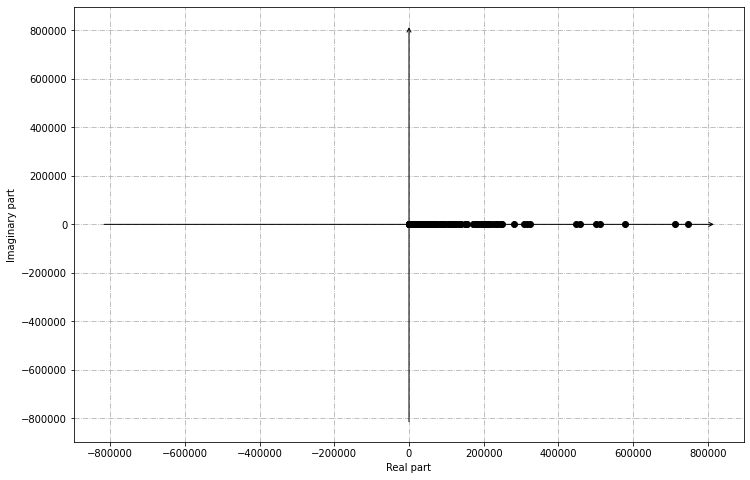

In [8]:
spod.plot_eigs()

We can then plot the **eigenvalues as a function of frequency and period** (note that we multiply the frequency by 4, that is the factor going from 6 hours of time-step to 1 day, so that we obtain a period for the x-axis in days). Again, we can see how thorough the `PySPOD` object returned after the computation we can access the frequency array (`spod.freq`) along with the plotting methods `spod.plot_eigs_vs_frequency` and `spod.plot_eigs_vs_period`.

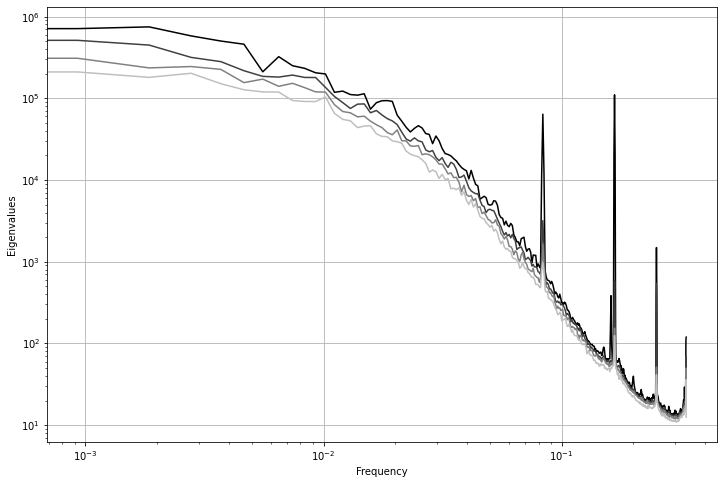

In [9]:
freq = spod.freq * 4 # (in days)
spod.plot_eigs_vs_frequency(freq=freq)

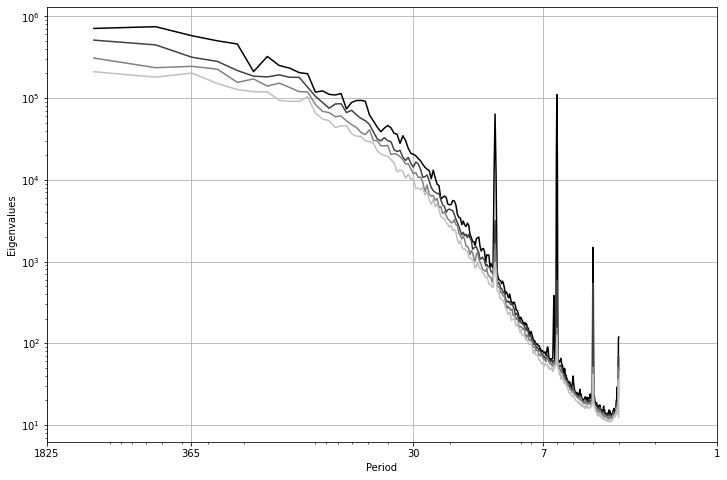

In [10]:
spod.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 1825])

We can then plot the **modes** that were computed by the SPOD algorithm via the built-in `plot_2D_modes_at_frequency` method, that can again be accessed via the `PySPOD` object returned after the computation. To this method, we pass the frequency of the modes we are interested in. This corresponds to the frequency associated to the T_approx of 876 days that we requested, and stored in the variable `freq_found` that we calculated above. Note that we also pass the `vars_idx` corresponding to the variable we are interested in, modes_idx corresponding to the modes we are interested in, as well as `x1`, and `x2`, that correspond to longitude and latitude. We finally pass a parameter `coastlines='centred'`, that overlays a world map on top of our data. Note that we **shift longitude of 180**, as we use coastlines that goes from -180, to 180, while our data was provided from 0 to 360. 

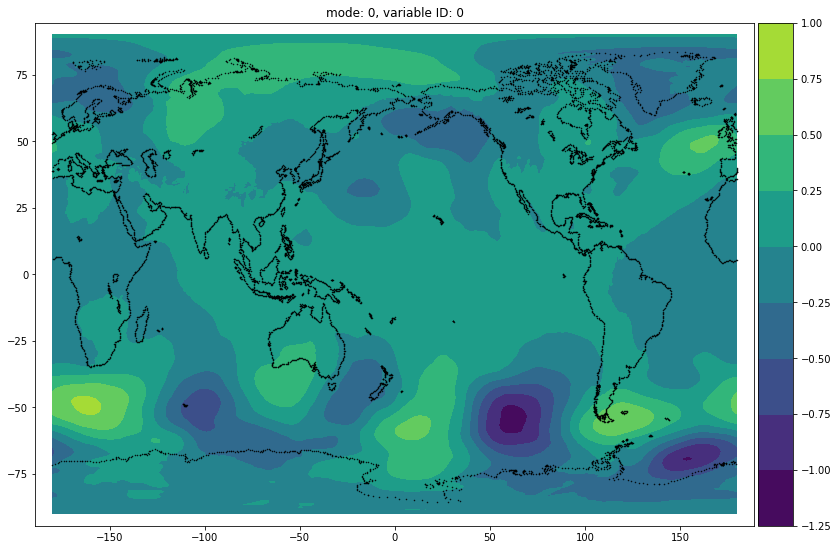

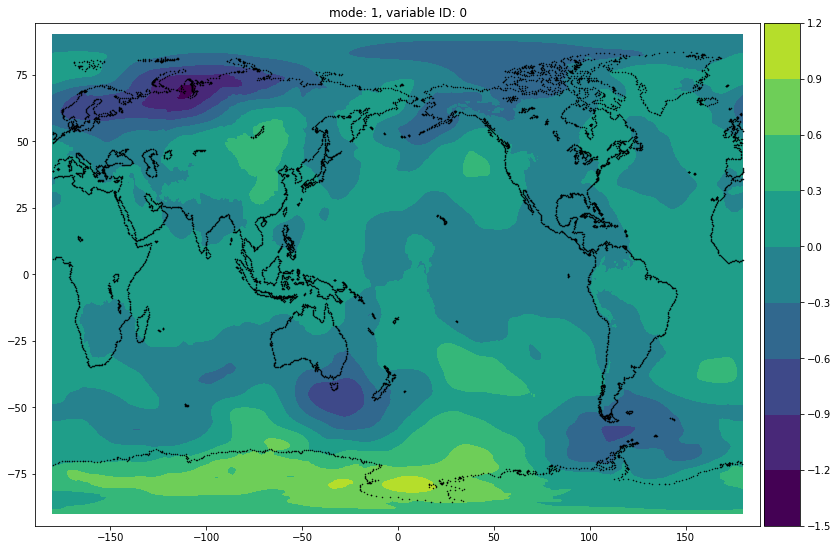

In [11]:
spod.plot_2D_modes_at_frequency(
	freq_required=freq_found, freq=freq, x1=x1-180, x2=x2, coastlines='centred', modes_idx=[0,1], vars_idx=[0])

Note that we can also plot the **original data** by

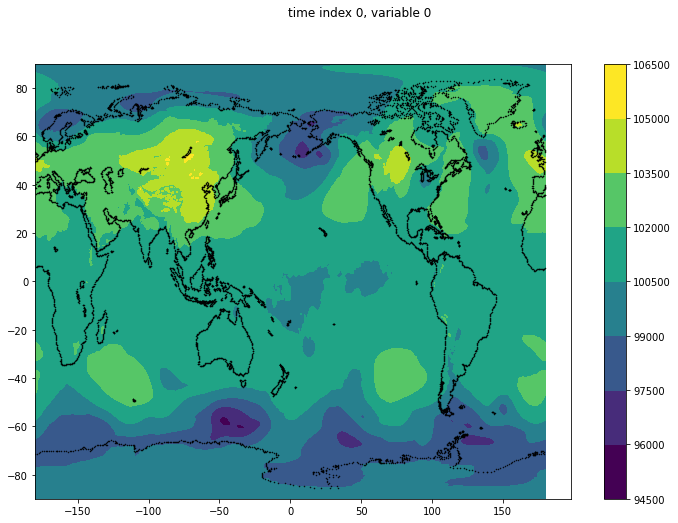

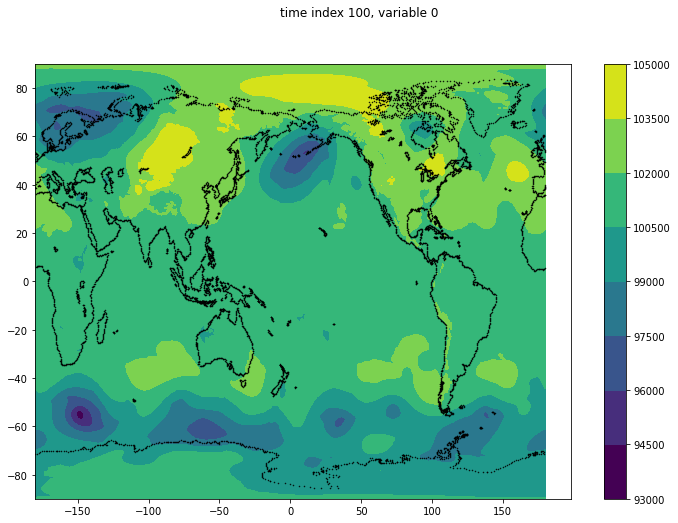

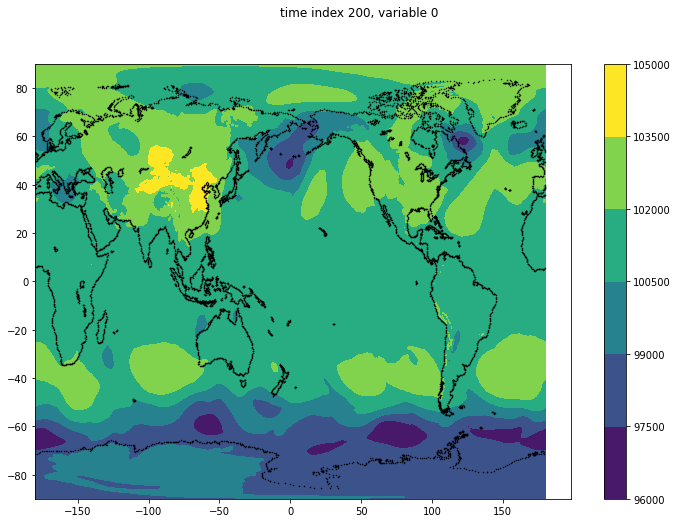

In [12]:
spod.plot_2D_data(x1=x1-180, x2=x2, coastlines='centred', vars_idx=[0], time_idx=[0,100,200])

## Final notes

The results are stored in the results folder defined in the parameter you specified under `params[savedir]`. We can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exists several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to you specific post-processing pipeline.

This tutorial was intended to help you setup your own multivariate case. You can play with the parameters we explored above to gain more insights into the capabilities of the library. You can also run on the same data the other two SPOD algorithms implemented as part of this library by simply calling:
- SPOD_analysis = SPOD_low_storage(data=X, params=params, file_handler=False)
- SPOD_analysis = SPOD_streaming(data=X, params=params, file_handler=False)

and compare the results.

**NOTE: for this tutorial we also provide a file `ERA5_RA_2019_MSLP_large.py`, through which you can download hourly seal-level pressure data for 2019. The dataset is ~18GB, in case you want to try a higher resolution analysis.**